In [27]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import os

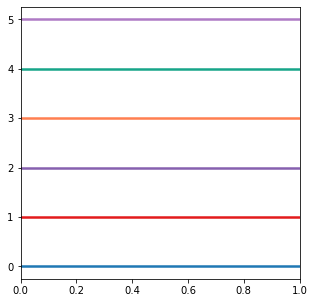

In [28]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

new_cmap = [ '#1F78B4', '#E31A1C', '#8660AF', '#FF7F50', '#17A589', '#AF7AC5']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,6))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [29]:
oligomersizes = np.arange(2, 61, 2)
nr_frames_out = 15001
MATH_out_cutoff = 5.2
calcpath='../Reweighting_pipeline/calc_data_MATHfree'

In [30]:
os.system('mkdir figures/extendedMATH_subsample')

mkdir: cannot create directory ‘figures/extendedMATH_subsample’: File exists


256

In [31]:
def save_pickle(filename, pickle_obj):
    with open(filename, 'wb') as f:
        pkl.dump(pickle_obj, f)

def load_pickle(filename):
    with open(filename, 'rb') as f:
        loaded_obj = pkl.load(f)
        
    return loaded_obj

In [32]:
#Loads experimental SAXS q, I and err - in BME format
def load_exp_SAXS(exp_file):
    q, I, err = np.genfromtxt(exp_file, usecols=(0,1,2), skip_header=0, unpack=True)
    return np.array(q), np.array(I), np.array(err)

#Loads SAXS intensities calculated from simulations - in BME format
def load_sim_SAXS(calc_file):
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(calc_file) if("#" not in line)])
    return np.array(calc_data)

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value

#Calculate concentrations with isodesmic model
#Returns array of oligomer concentrations
def isodesmic(Ka, Ctot, oligomersizes):
    
    BTBdimer_conc = Ctot/2.0
    
    C = []
    
    #Calculate monomer concentration
    conc = (2*BTBdimer_conc*Ka+1-np.sqrt(4*BTBdimer_conc*Ka+1))/(2*BTBdimer_conc*(Ka**2))
    C.append(conc)
    
    #Calculate oligomer concentrations
    for i in range(1,len(oligomersizes)):
        conc = Ka*C[i-1]*C[0]
        C.append(conc)
        
    return np.array(C)

def get_chi2(Iaverage_sim, I_exp, err_exp):
    
    chi2 = np.average(np.square((Iaverage_sim-I_exp)/err_exp))
    
    return chi2

#Fit calc data profiles scale and offset with linear regression
def fit_scale_offset(Iaverage_sim, I_exp, err_exp):
    #Get weight for each point based on exp error
    sample_weight=1.0/(err_exp**2)
    
    #Linear regression
    reg = LinearRegression(fit_intercept=True).fit(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    r_value = reg.score(Iaverage_sim.reshape(-1,1),I_exp.reshape(-1,1),sample_weight=sample_weight)
    slope,intercept = reg.coef_[0],reg.intercept_
    
    Iaverage_sim_fit = Iaverage_sim*slope+intercept
    
    return Iaverage_sim_fit, slope, intercept, r_value


In [33]:
sel_frames_vs_size = []

for size in oligomersizes:
        
    dist_vs_subunit = np.array(load_pickle(f'pickles/MATHfree/dist_vs_subunit_{size}mer.pkl'))
    dist_avg = np.average(dist_vs_subunit, axis=0)
    
    acceptable_frames = np.nonzero(dist_avg > MATH_out_cutoff)[0]
    print(f'{size}mer has {len(acceptable_frames)} frames that work')
    sel_frames = np.random.choice(acceptable_frames, nr_frames_out)
    sel_frames_vs_size.append(sel_frames)
    

2mer has 2688 frames that work
4mer has 13445 frames that work
6mer has 7167 frames that work
8mer has 8398 frames that work
10mer has 5814 frames that work
12mer has 5724 frames that work
14mer has 147 frames that work
16mer has 4279 frames that work
18mer has 2386 frames that work
20mer has 2604 frames that work
22mer has 112 frames that work
24mer has 2725 frames that work
26mer has 1461 frames that work
28mer has 1595 frames that work
30mer has 1241 frames that work
32mer has 949 frames that work
34mer has 513 frames that work
36mer has 597 frames that work
38mer has 4 frames that work
40mer has 1136 frames that work
42mer has 261 frames that work
44mer has 60 frames that work
46mer has 203 frames that work
48mer has 138 frames that work
50mer has 36 frames that work
52mer has 112 frames that work
54mer has 51 frames that work
56mer has 36 frames that work
58mer has 48 frames that work
60mer has 46 frames that work


# Plot subsampled MATH-BTB/BACK distances

In [34]:
dist_all = np.array([])
dist_all_subsampled = np.array([])


for i,size in enumerate(oligomersizes):
    
    #Load pickles
    dist_vs_subunit = np.array(load_pickle(f'pickles/MATHfree/dist_vs_subunit_{size}mer.pkl'))
    dist_vs_subunit_subsampled = dist_vs_subunit[...,sel_frames_vs_size[i]] 
    
    dist_all_subsampled = np.concatenate((dist_all_subsampled, dist_vs_subunit_subsampled.flatten()))
    dist_all = np.concatenate((dist_all, dist_vs_subunit.flatten()))

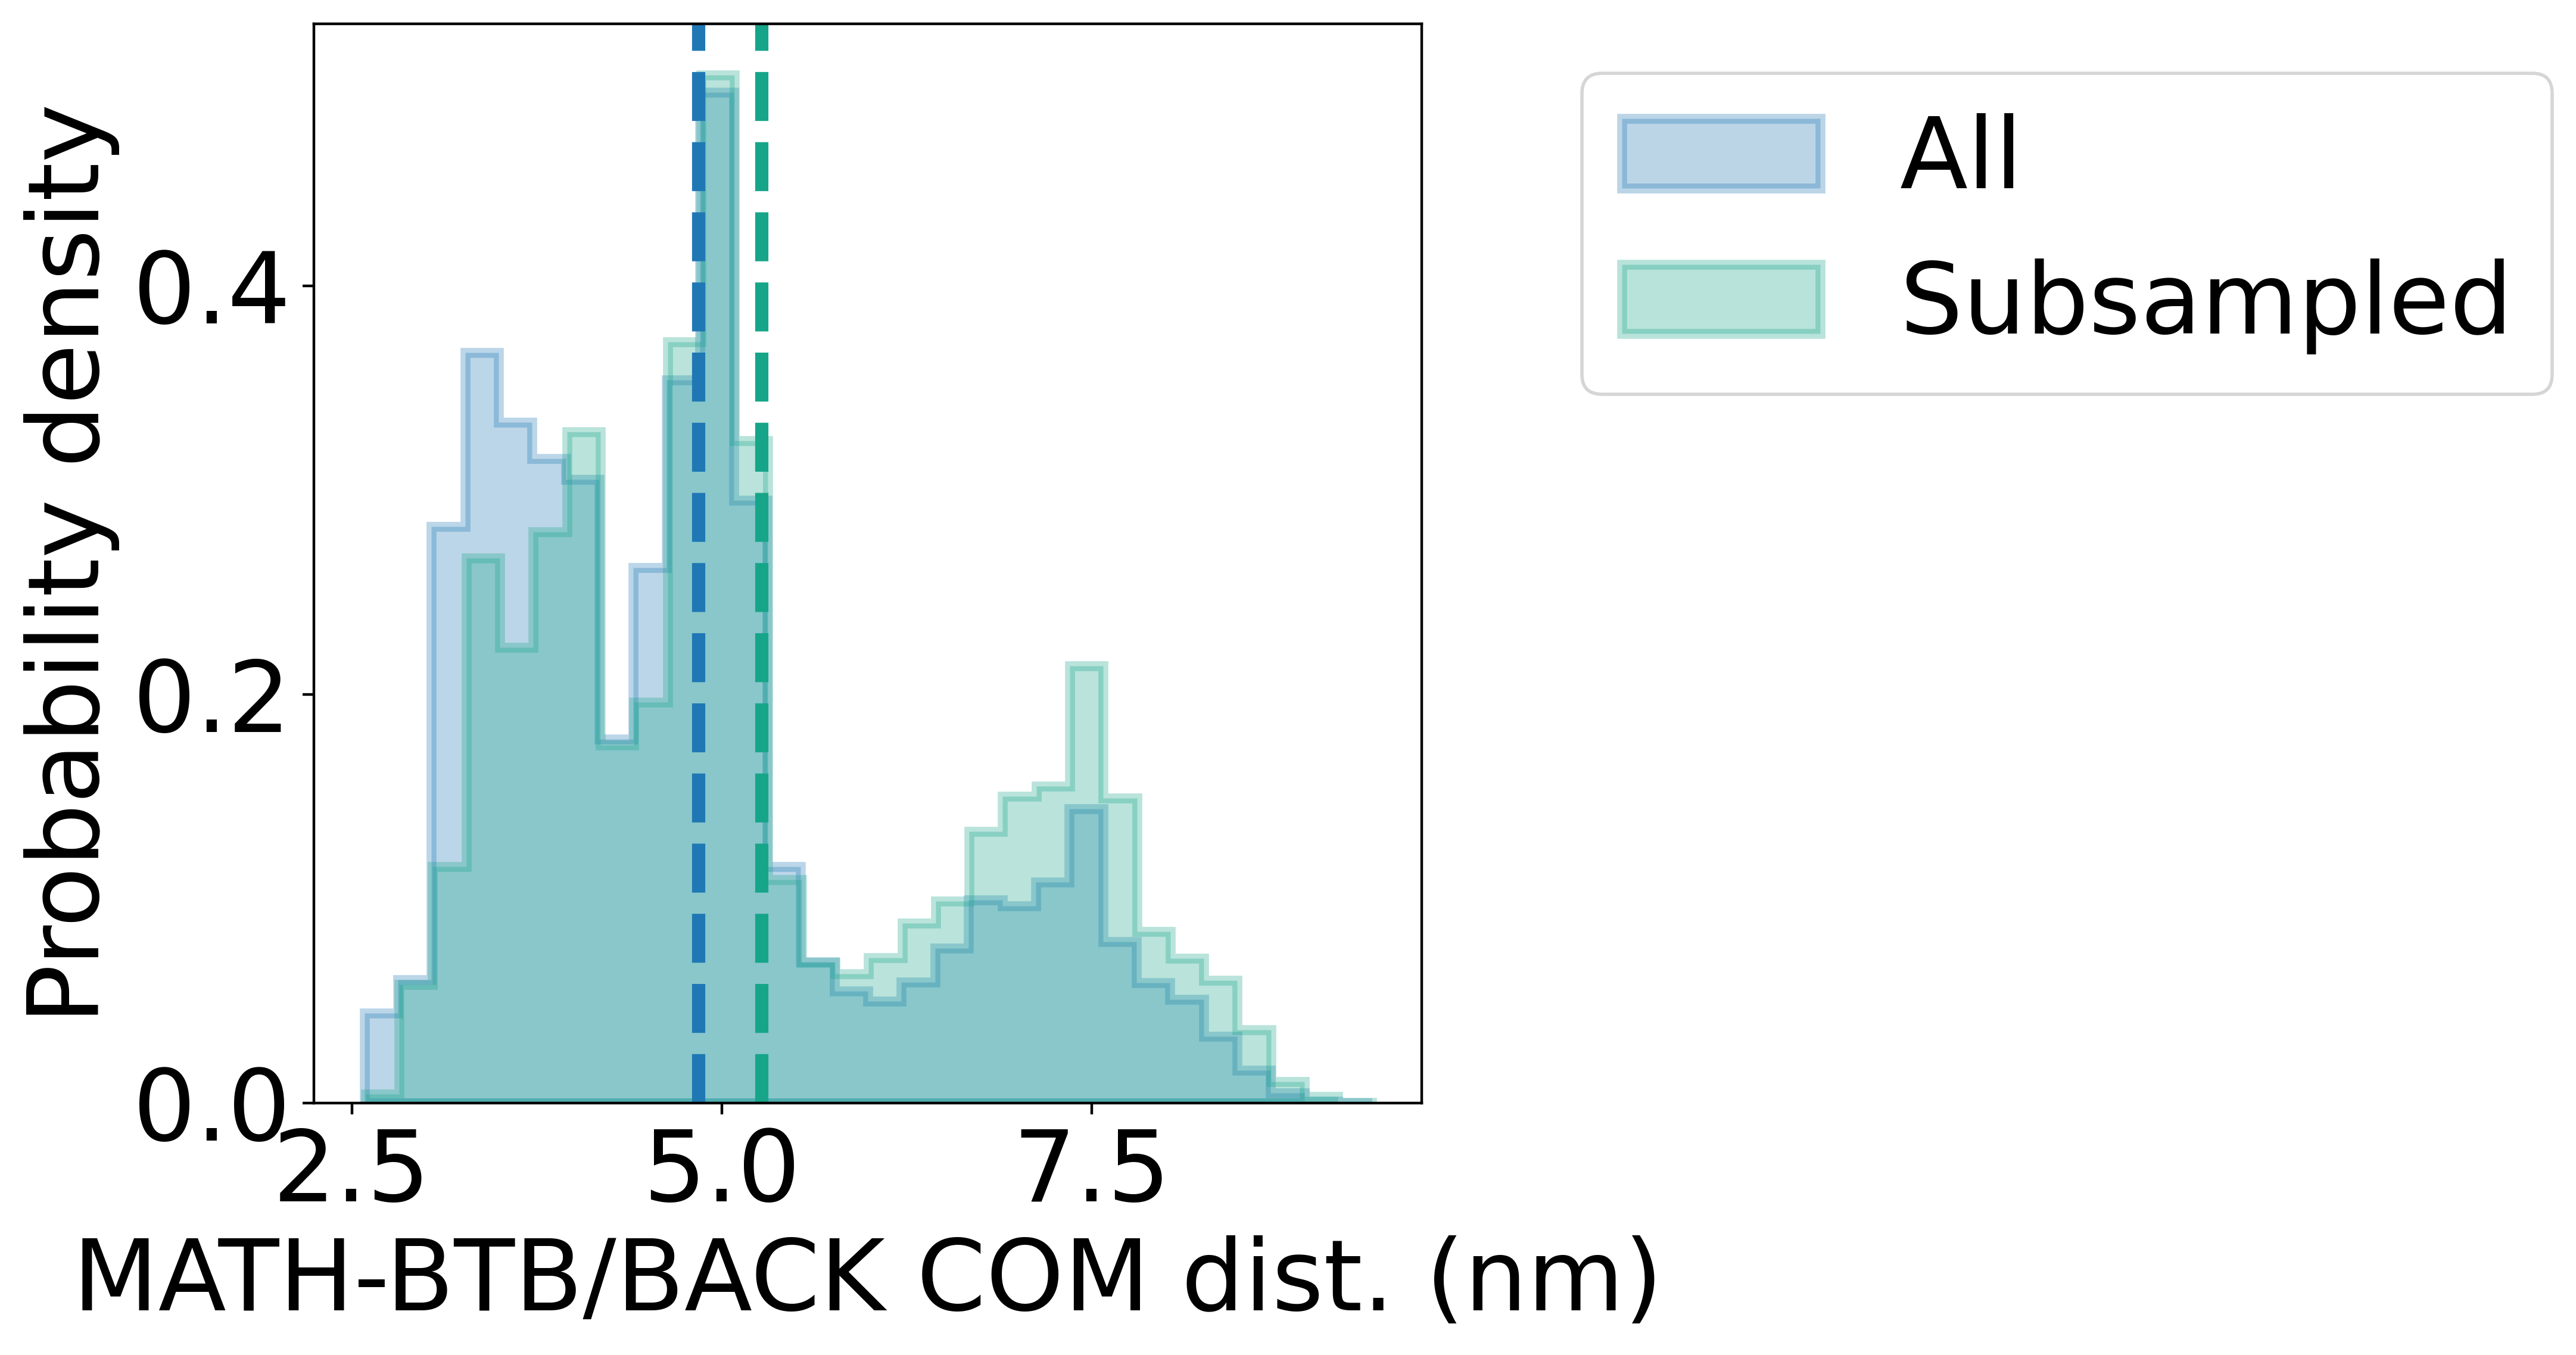

In [35]:
#All MATH-BTB/BACK distance histogram

#Start plot
fig = plt.figure(figsize=(6,6), dpi=400)
#plt.title(f'', fontsize=30)
plt.xlabel('MATH-BTB/BACK COM dist. (nm)', fontsize=30)
plt.ylabel('Probability density', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=30)

#Plot all
dist_all_hist = plt.hist(dist_all, density=True, color=colors[0], alpha=0.3, bins=30, histtype='stepfilled', edgecolor=colors[0], linewidth=3, label='All')
plt.axvline(np.average(dist_all),linewidth=4, linestyle='--', alpha=1, color=colors[0])


#Plot subsampled
dist_all_hist = plt.hist(dist_all_subsampled, density=True, color=colors[4], alpha=0.3, bins=30, histtype='stepfilled', edgecolor=colors[4], linewidth=3, label='Subsampled')
plt.axvline(np.average(dist_all_subsampled),linewidth=4, linestyle='--', alpha=1, color=colors[4])


#Legend
plt.legend(fontsize=30, ncol=1, bbox_to_anchor=(1.10, 1.0))

#Save
fig.savefig(f"figures/extendedMATH_subsample/MATH_BTBBACK_distance_subunitshistogram.pdf", bbox_inches='tight', pad_inches=1)

# Plot subsampled Rg distributions

15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001
15001


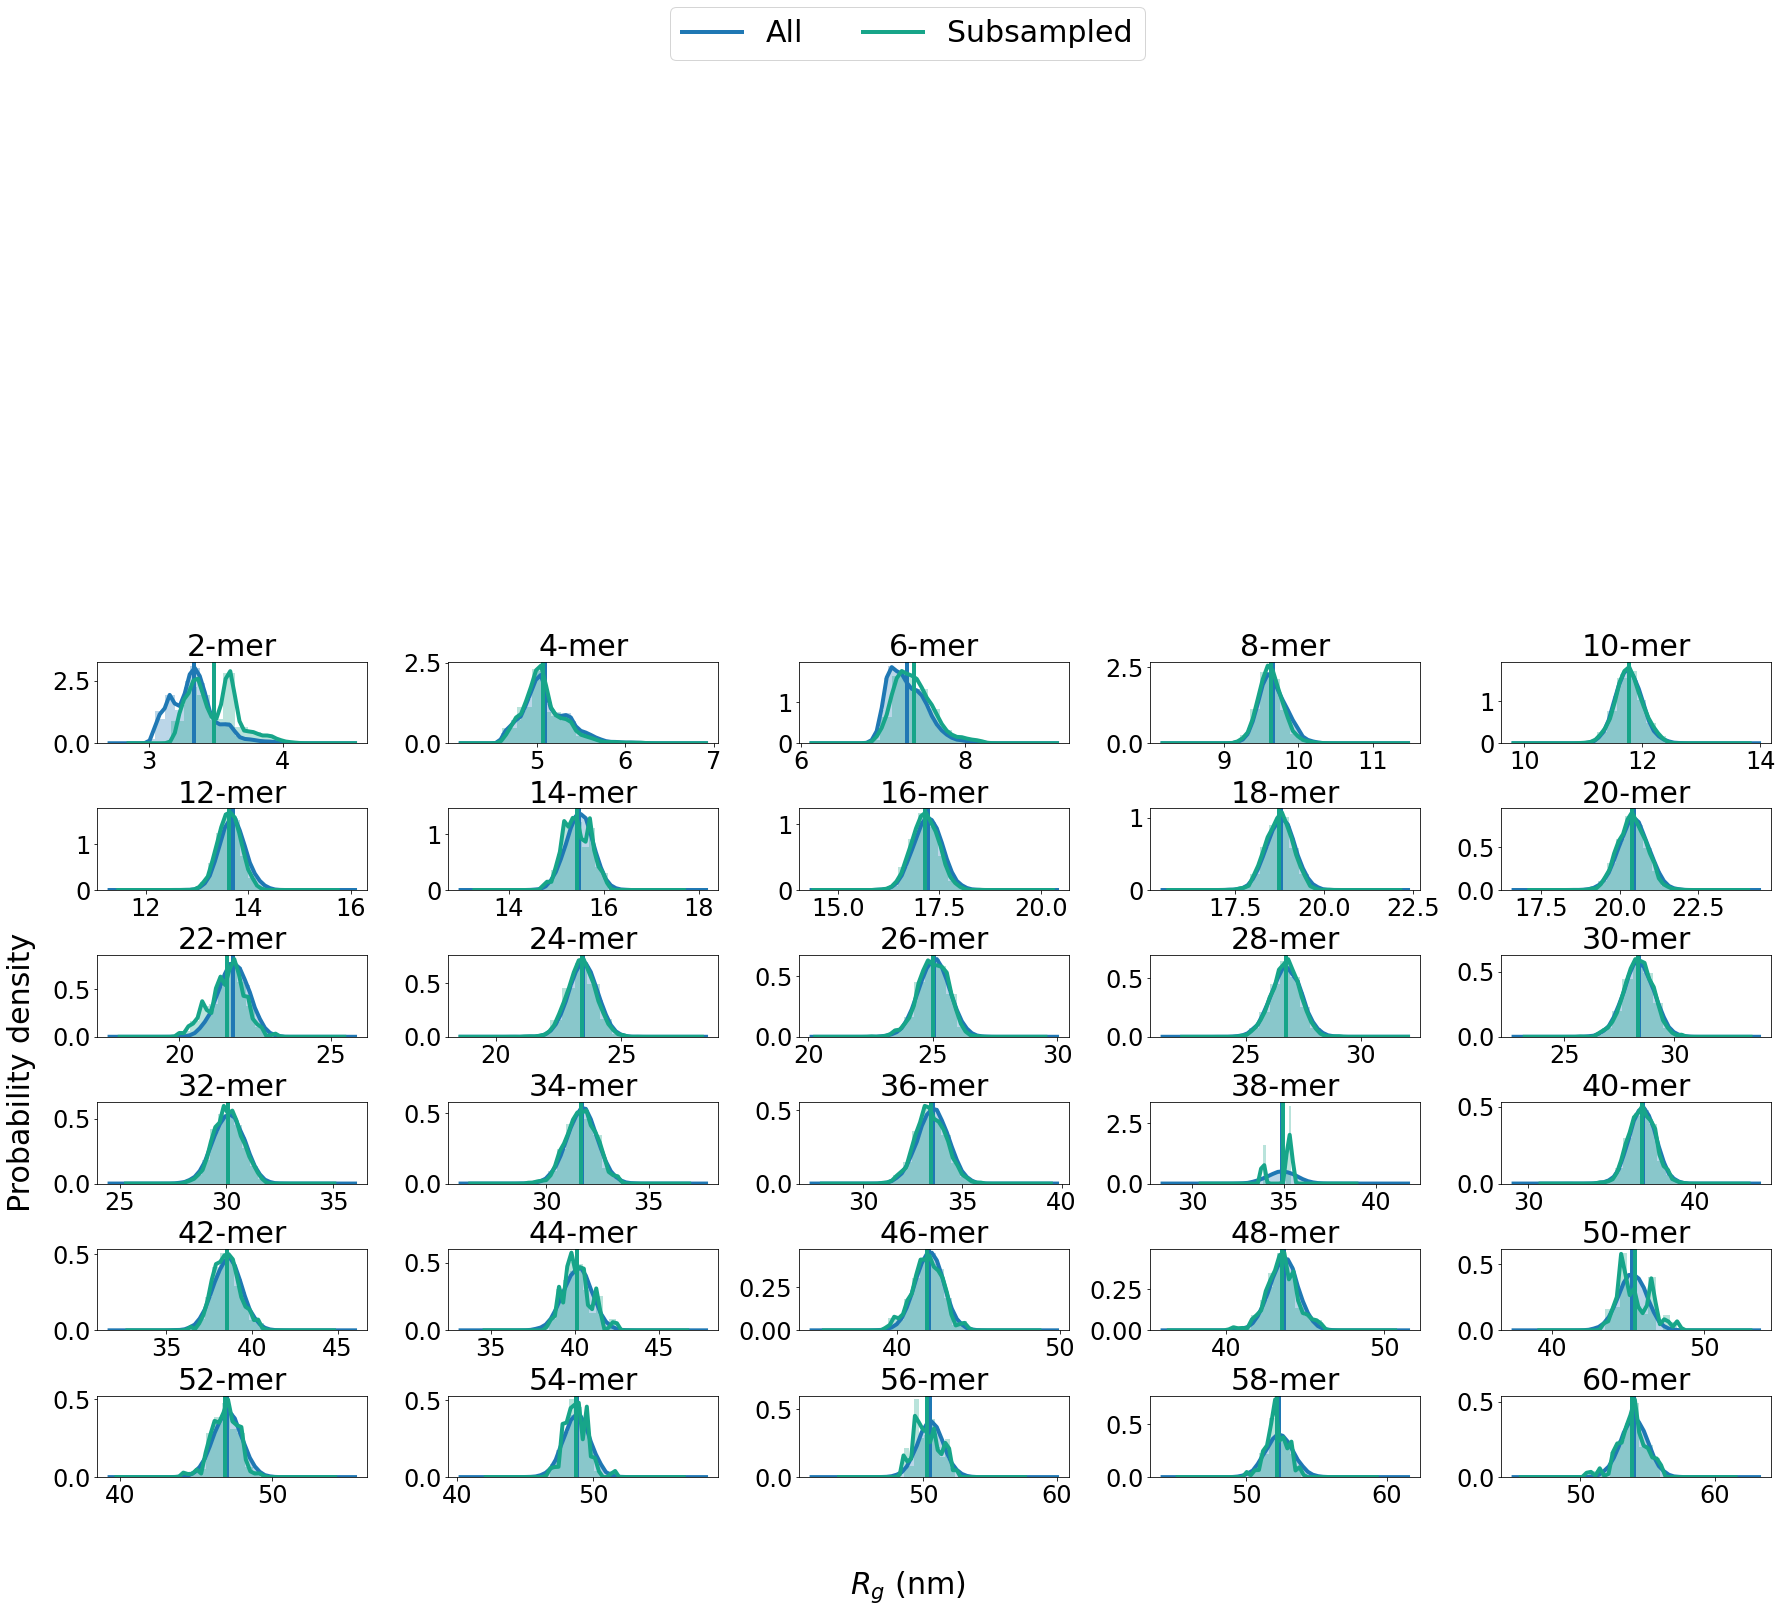

In [36]:
#Start plot
fig, ax = plt.subplots(figsize=(30,15), nrows=6, ncols=5)    
plt.subplots_adjust(hspace = 0.8, wspace=0.3)
fig.text(0.5, 0.04, '$R_g$ (nm)', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.5, 'Probability density', ha='center', va='center', fontsize=30, rotation=90)

k=0
n=0
for i,size in enumerate(oligomersizes):
    
    #Get Rg from file
    time, Rg = np.genfromtxt(f'MATHfree_runs/SPOP_{size}mer/Rg_gyrate_AA.xvg', usecols=(0,1), skip_header=27, unpack=True)
    Rg_subsampled = Rg[sel_frames_vs_size[i]] 
    print(len(Rg_subsampled))
    
    #Plot title
    ax[k,n].set_title(f'{size}-mer', fontsize=30)
    
    #KDE
    kde_x = np.linspace( np.amin(Rg)*0.9, np.amax(Rg)*1.1, num = 50 )
    kde_y = stats.gaussian_kde(Rg, bw_method = "silverman").evaluate(kde_x)
    
    #Plot
    ax[k,n].hist(Rg, density=True, color=colors[0], alpha=0.3, bins=30)
    ax[k,n].plot(kde_x, kde_y, '-', linewidth=4, color=colors[0])
    if k==0 and n==0:
        ax[k,n].axvline(np.average(Rg),linewidth=4, alpha=1, color=colors[0], label='All')
    else:
        ax[k,n].axvline(np.average(Rg),linewidth=4, alpha=1, color=colors[0])

    #KDE
    kde_x = np.linspace( np.amin(Rg_subsampled)*0.9, np.amax(Rg_subsampled)*1.1, num = 50 )
    kde_y = stats.gaussian_kde(Rg_subsampled, bw_method = "silverman").evaluate(kde_x)
    
    #Plot
    ax[k,n].hist(Rg_subsampled, density=True, color=colors[4], alpha=0.3, bins=10)
    ax[k,n].plot(kde_x, kde_y, '-', linewidth=4, color=colors[4])
    if k==0 and n==0:
        ax[k,n].axvline(np.average(Rg_subsampled),linewidth=4, alpha=1, color=colors[4], label='Subsampled')
    else:
        ax[k,n].axvline(np.average(Rg_subsampled),linewidth=4, alpha=1, color=colors[4])
    
    ax[k,n].tick_params(axis='both', which='major', labelsize=24)
    
    #Iterate over plot panel indeces
    n+=1
    if n==5:
        n=0
        k+=1

#Add legend
fig.legend(fontsize=30, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=2)

#Save
fig.savefig("figures/extendedMATH_subsample/Rg_distributions.pdf", bbox_inches='tight', pad_inches=1)


# SAXS using CG-MALS Kd

In [37]:
Ka = 0.625
concs=[5.0, 10.0, 20.0, 30.0, 40.0]

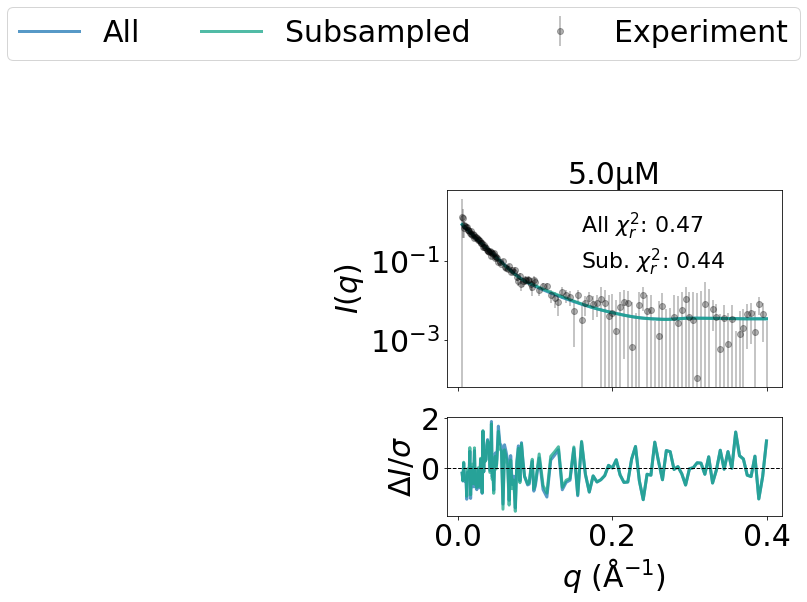

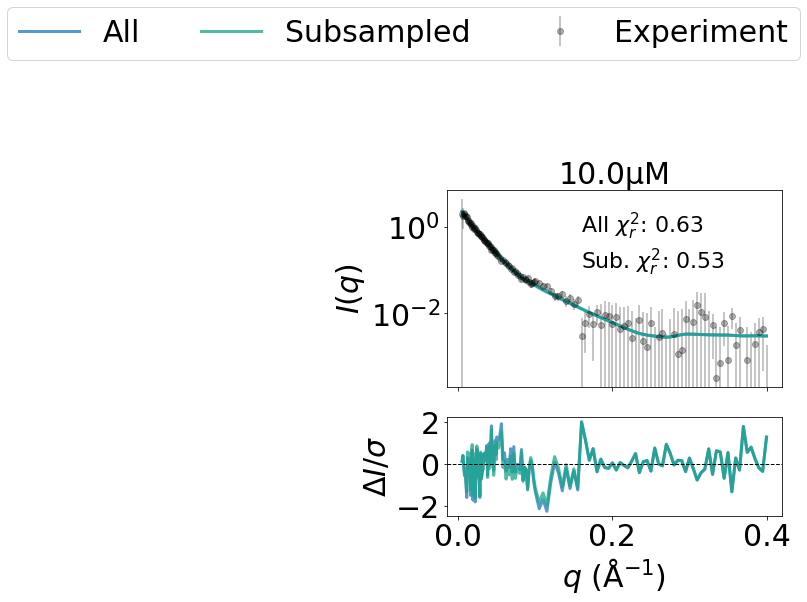

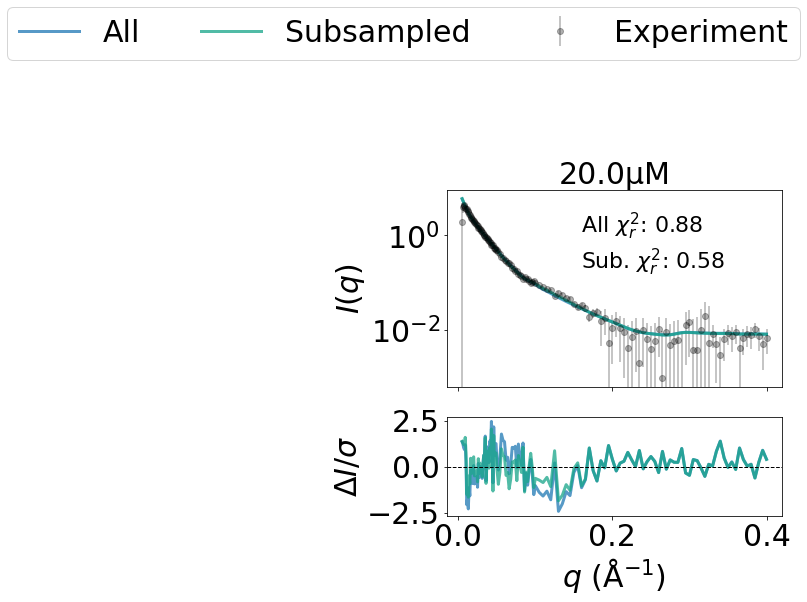

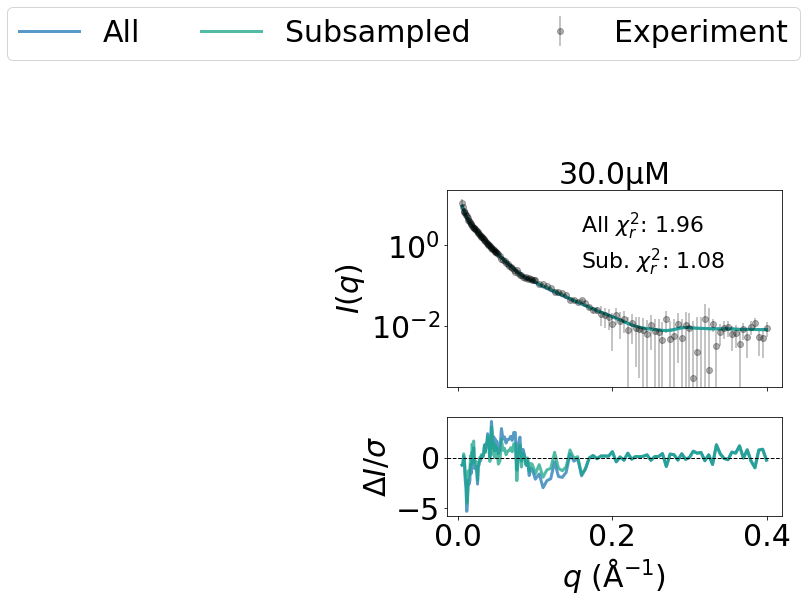

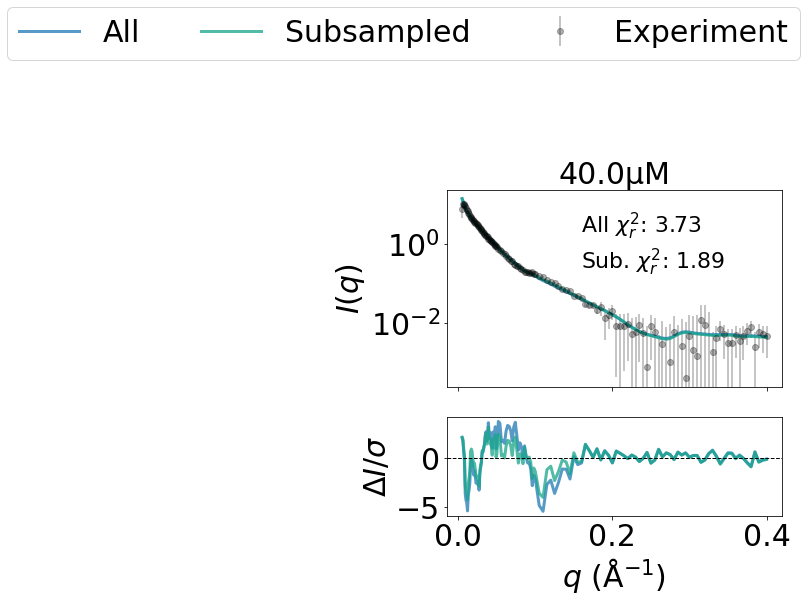

In [38]:
#Make array of simulation SAXS data
calc_data = []
calc_data_subsampled = []

for i,oligomersize in enumerate(oligomersizes):
    simSAXS = load_sim_SAXS(f'{calcpath}/calc_data_{oligomersize}mer.dat')
    calc_data.append(simSAXS)
    
    simSAXS_subsampled = simSAXS[sel_frames_vs_size[i]]
    calc_data_subsampled.append(simSAXS_subsampled)
    
calc_data = np.array(calc_data)
calc_data_subsampled = np.array(calc_data_subsampled)


chi2_global_subsampled = 0
chi2_global_all = 0
for conc in concs:
    #Get experimental SAXS profile
    exp_file = f'../Reweighting_pipeline/WT_MATHfree_scaleoffsetonly/exp_data_{conc}uM.dat'
    q, Iexp, err_exp = load_exp_SAXS(exp_file)


    #SUBSAMPLED ENSEMBLE
    Iaverage_vs_size_subsampled = np.average(calc_data_subsampled, axis=1)

    #Calculate SAXS
    isodesmic_concs = isodesmic(Ka, conc, oligomersizes)
    volume_weights = isodesmic_concs*oligomersizes
    volume_weights = volume_weights/np.sum(volume_weights)

    Iaverage = np.sum(Iaverage_vs_size_subsampled*volume_weights[:,np.newaxis],axis=0)

    Iaverage_scale_offset_subsampled, slope, intercept, r_value = fit_scale_offset(Iaverage, Iexp, err_exp)

    chi2_subsampled = get_chi2(Iaverage_scale_offset_subsampled, Iexp, err_exp)

    chi2_global_subsampled += chi2_subsampled


    #FULL ENSEMBLE
    Iaverage_vs_size = np.average(calc_data, axis=1)

    #Calculate SAXS with fitted Ka (for subsampled)
    isodesmic_concs = isodesmic(Ka, conc, oligomersizes)
    volume_weights = isodesmic_concs*oligomersizes
    volume_weights = volume_weights/np.sum(volume_weights)

    Iaverage = np.sum(Iaverage_vs_size*volume_weights[:,np.newaxis],axis=0)

    Iaverage_scale_offset, slope, intercept, r_value = fit_scale_offset(Iaverage, Iexp, err_exp)

    chi2 = get_chi2(Iaverage_scale_offset, Iexp, err_exp)

    chi2_global_all += chi2

    #RESIDUALS
    residuals = (Iaverage_scale_offset - Iexp)/err_exp
    residuals_subsampled = (Iaverage_scale_offset_subsampled - Iexp)/err_exp



    #Plot SAXS data
    #SAXS figure
    fig, ax = plt.subplots(figsize = (6,6), nrows=2, sharex='col', sharey='row', gridspec_kw={'height_ratios': [4, 2]})

    ax[0].set_title(f'{conc}µM', fontsize=30)

    ax[0].errorbar(q, Iexp, yerr=err_exp, fmt='o', markersize=6, color='black', alpha=0.3, label='Experiment')
    ax[0].plot(q, Iaverage_scale_offset, linewidth=3, label="All", alpha=0.75, color=colors[0])
    ax[0].plot(q, Iaverage_scale_offset_subsampled, linewidth=3, label="Subsampled", alpha=0.75, color=colors[4])

    ax[0].semilogy()
    ax[0].set_ylabel('$I(q)$', fontsize=30)
    ax[0].legend(fontsize=30, ncol=6, bbox_to_anchor=(1.1, 2.0))
    ax[0].text(0.40,0.60, f'All $χ^2_r$: {chi2:.2f} \nSub. $χ^2_r$: {chi2_subsampled:.2f}', fontsize=22, transform=ax[0].transAxes)

    for j in range(len(ax)):
        ax[j].tick_params(axis='both', which='major', labelsize=30)

    ax[1].plot(q, residuals, linewidth=3, color= colors[0], alpha=0.75)
    ax[1].plot(q, residuals_subsampled, linewidth=3, color= colors[4], alpha=0.75)

    ax[1].set_ylabel('$ΔI/σ$', fontsize=30)
    ax[1].set_xlabel('$q$ (Å$^{-1}$)', fontsize=30)
    ax[1].axhline(0, ls='--', linewidth=1, color='black')

    fig.savefig(f"figures/extendedMATH_subsample/SAXS_{conc}uM_Ka{Ka}.pdf", bbox_inches='tight', pad_inches=1, dpi=400)
    
chi2_global_all /= len(concs)
chi2_global_subsampled /= len(concs)

In [39]:
print(f'chi2 full ensemble: {chi2_global_all}, chi2 subsampled ensemble: {chi2_global_subsampled}')

chi2 full ensemble: 1.5343662373320872, chi2 subsampled ensemble: 0.9034919704673016
